In [1]:
import pandas as pd
import os

In [2]:
r = 2

min_start_len = 5000*r
min_start_ratio = 0.8
max_merge_dist = 1000*r
dbscan_eps = 1000*r
min_len_after_split_strand = 1000*r
min_len_after_split_dbscan = 2000*r
min_len_after_split = 1000*r
graph_sim_ratio = 0.8

dset = 'part05_chinese_pangolin'
res_dir = '../results_a4/' + dset + '/'
os.makedirs(res_dir, exist_ok=True)

# preprocessing

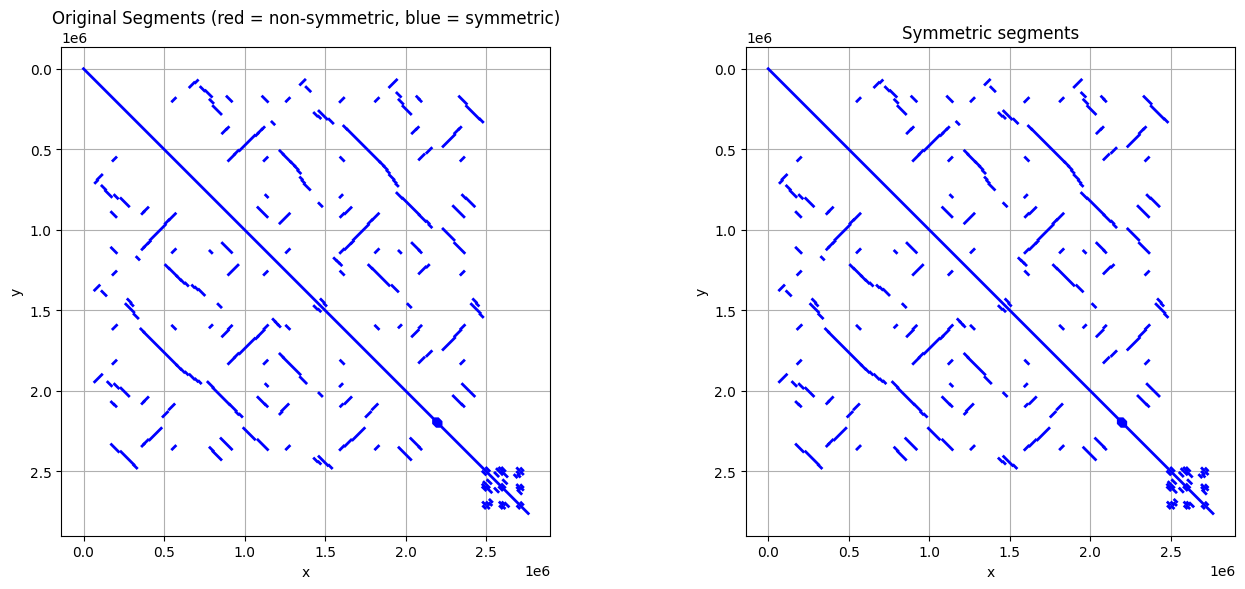

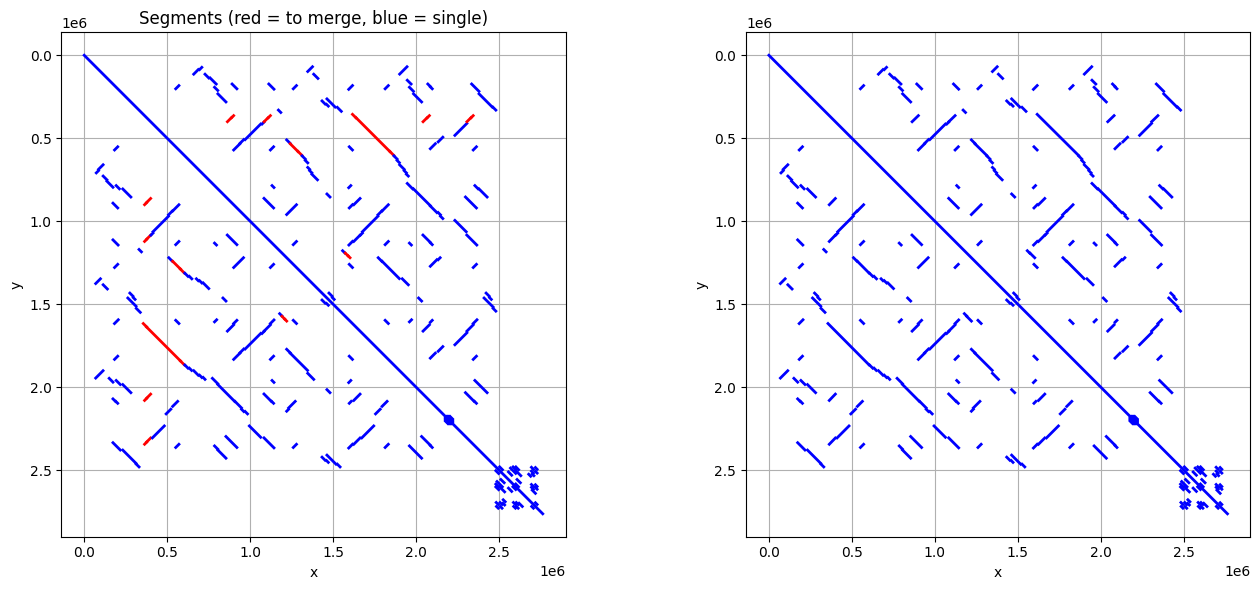

In [3]:
from importlib import reload

import utilx1
reload(utilx1)
from utilx1 import preprocess, merge_segments, symmetric

species_id = 0
species_name = 'chinese_pangolin'

df1 = pd.read_csv('../a1_fasta/patchwork_output_chinese_pangolin_part05/pairwise_alignments/self_0-chinese_pangolin_IGK.tsv', sep='\t')
df2 = preprocess(df1, min_start_len, min_start_ratio)
df3 = symmetric(df2, plot=True)
df4 = merge_segments(df3, threshold=1000, plot=True)

# negative strands

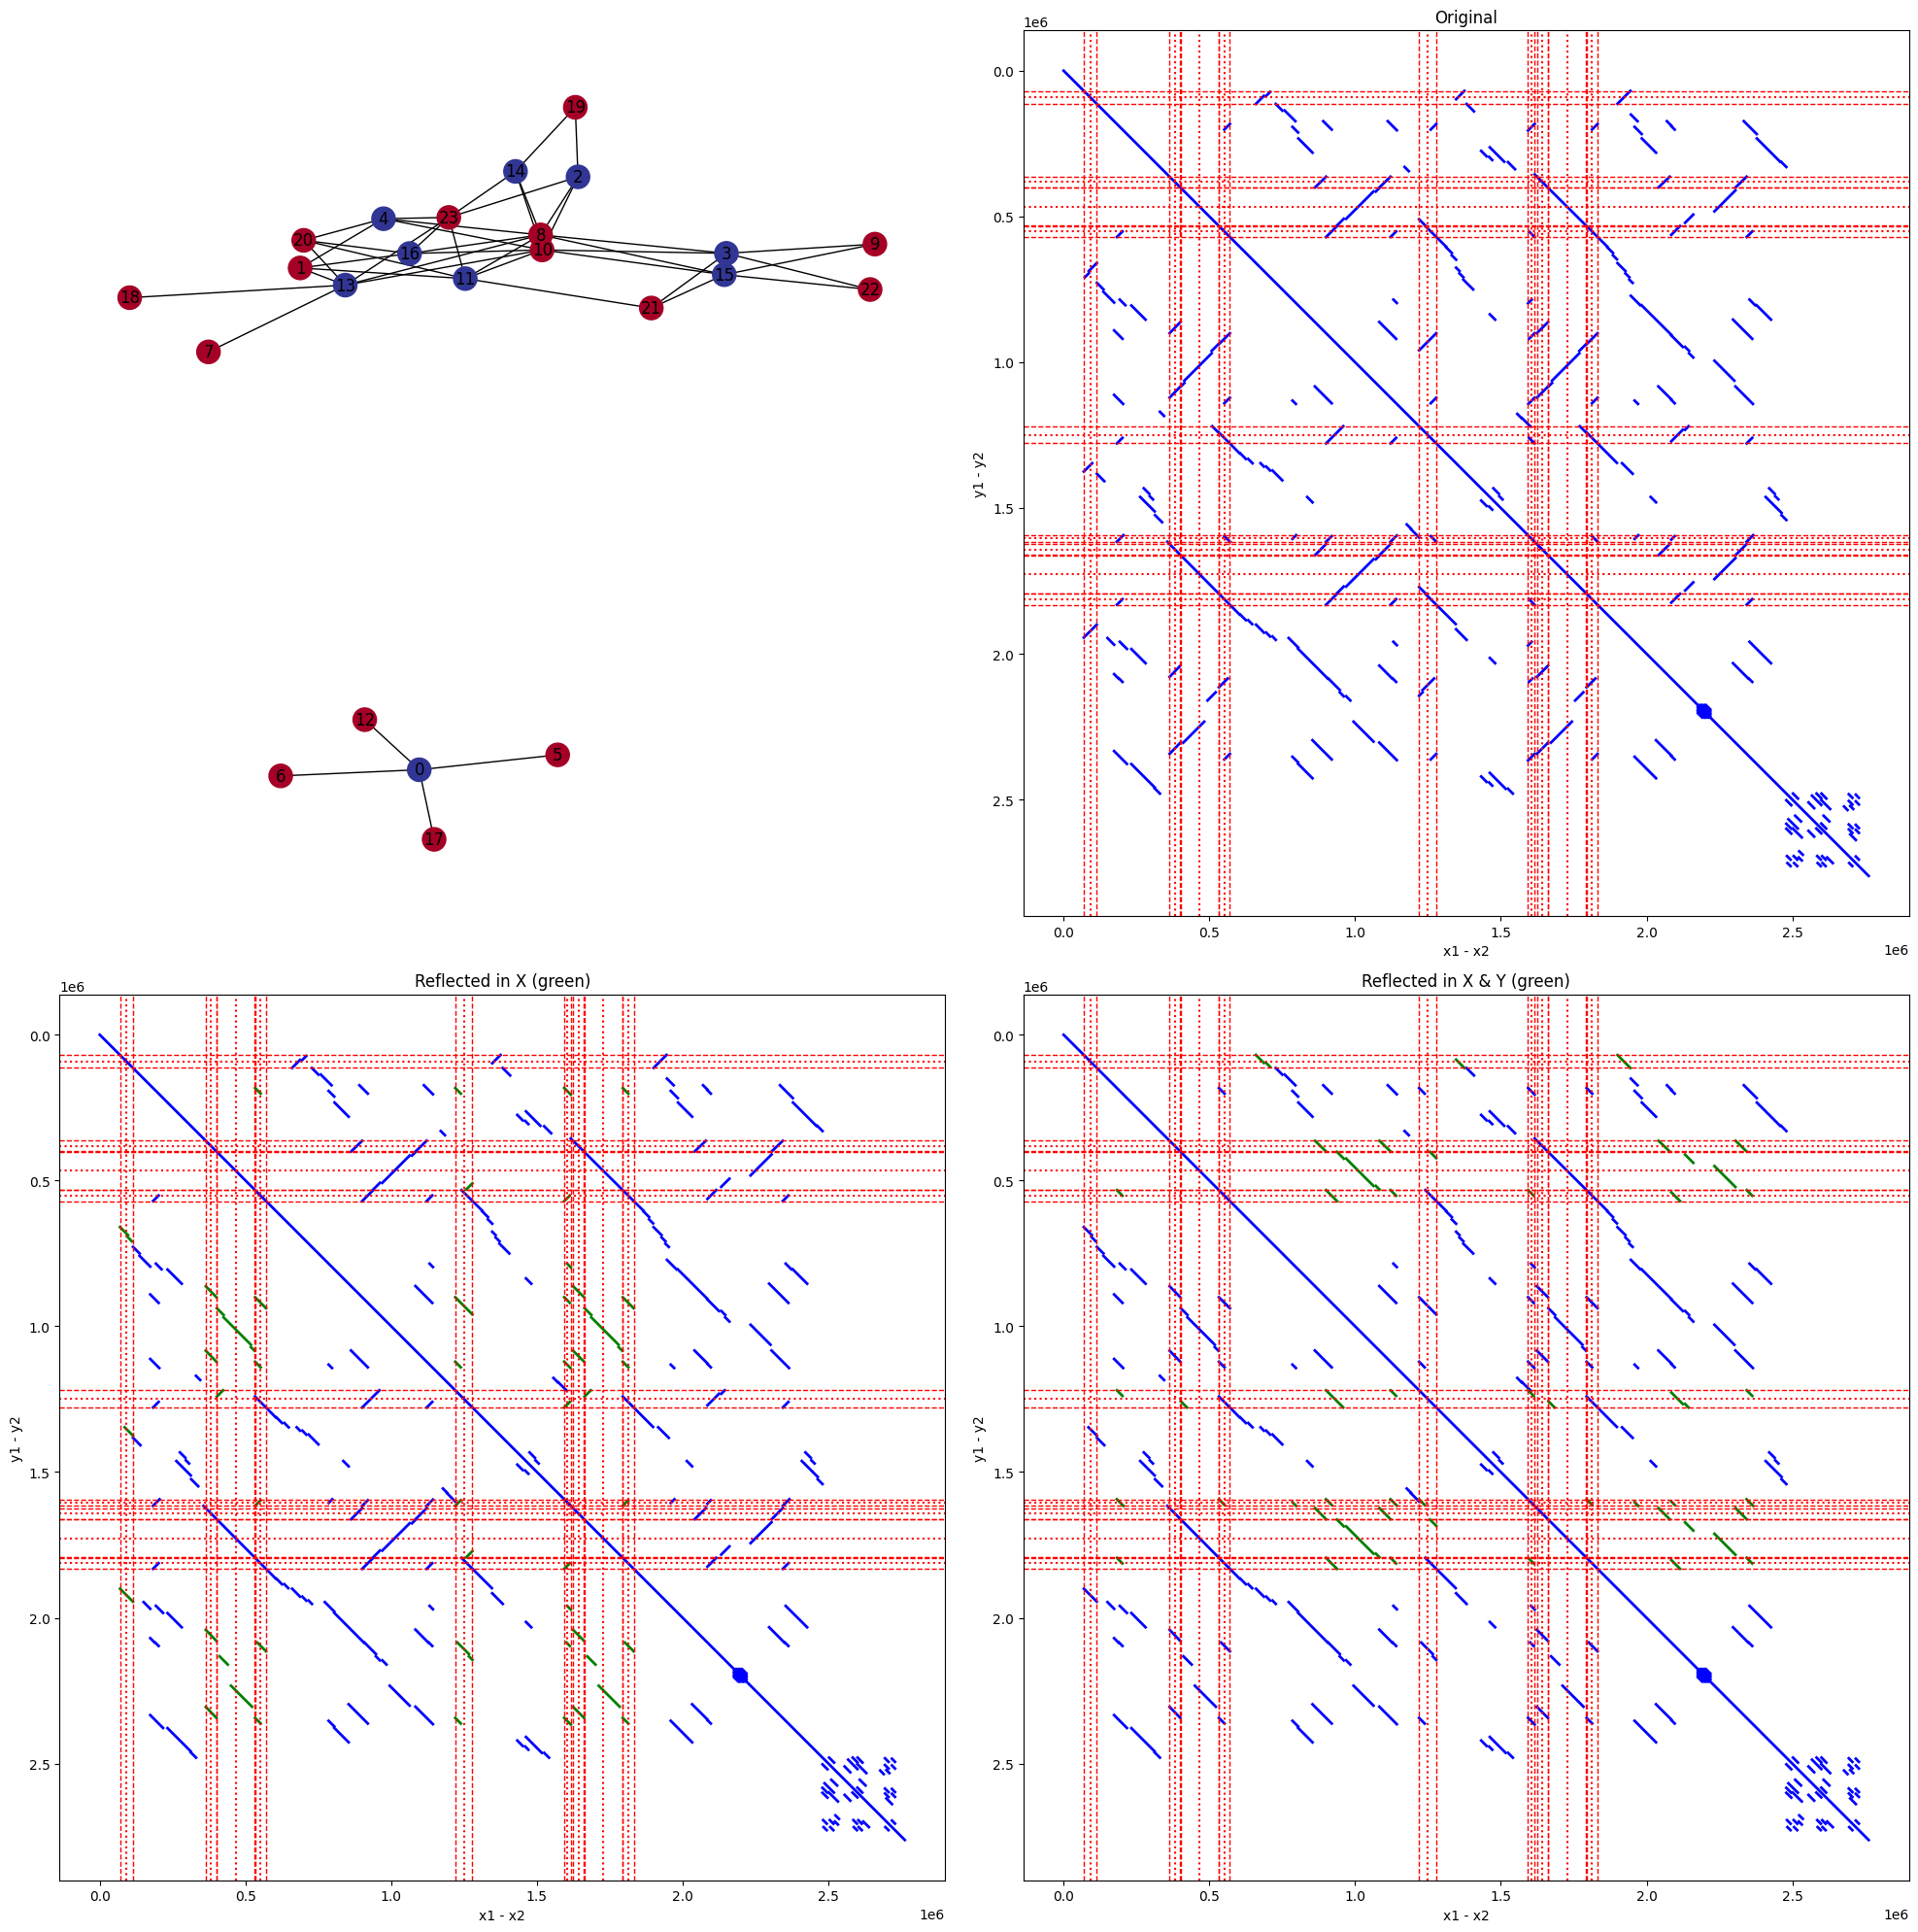

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

import utilx1
reload(utilx1)
from utilx1 import find_negative_sites, find_negative_set, reflect_segments_with_visuals

import utilx2
reload(utilx2)
from utilx2 import split_segments_by_values

df5, df5_sites = find_negative_sites(df4)
negative_dict = find_negative_set(df5, df5_sites, plot=False)
df4_v2 = df4.copy()
r = 0
while negative_dict['is_bipartite'] == False:
    print(r, ':', df4_v2.shape[0])
    r+=1
    G = negative_dict['graph']

    tris = []
    triangles = [list(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    for tri in triangles:
        tris+=tri
    
    freq_dict = Counter(tris)
    df_freq = pd.DataFrame(freq_dict.items(), columns=['Value', 'Frequency'])
    df_freq = df_freq.sort_values(by=['Frequency', 'Value'], ascending=[False, True]).reset_index(drop=True)
    #try:
    s = df_freq.iloc[0].Value
    # except:
    #     odd_cycle = nx.find_cycle(G)
    #     cycle_nodes = [edge[0] for edge in odd_cycle] + [odd_cycle[0][0]]
    #     print(sorted(cycle_nodes), r%len(cycle_nodes))
    #     s = sorted(cycle_nodes)[r%len(cycle_nodes)]
    w = df5[(df5.y1>=df5_sites.iloc[s].x1_m) & (df5.y1<=df5_sites.iloc[s].x2_m)]

    split_points = list(w.y1) + list(w.y2)
    df4_v2 = split_segments_by_values(df4_v2, split_points_x = split_points, split_points_y = split_points, min_length = min_len_after_split_dbscan)
    df4_v2['strand2'] = df4_v2.apply(lambda row: '-' if row['y1'] > row['y2'] else '+', axis=1)
    df5, df5_sites = find_negative_sites(df4_v2)
    negative_dict = find_negative_set(df5, df5_sites, plot=False)

df6 = reflect_segments_with_visuals(pd.concat([df5, df4_v2[df4_v2.strand2=='+']]), negative_dict)

# beads

## найти отрезки с близкими проекциями начала или конца (разбить на кластеры), разрезать отрезки по этим границам

In [9]:
import utilx2
reload(utilx2)
from utilx2 import find_split_points_dbscan, split_segments_by_values, loop, make_fig

split_points = find_split_points_dbscan(df6, dbscan_eps)

df7 = split_segments_by_values(df6, split_points_x = split_points, split_points_y = split_points, min_length = min_len_after_split_dbscan)

split_points = list(df7.x1) + list(df7.x2)
df7, df8, connected_components = loop(df7, split_points, min_len_after_split, graph_sim_ratio)

while len(connected_components)>0:
    merged_list = [item for component in connected_components for item in component]
    df9 = df8[df8.cluster.isin(merged_list)]
    split_points = list(df9.x1) + list(df9.x2)
    df7, df8, connected_components = loop(df7, split_points, min_len_after_split, graph_sim_ratio)


Number of clusters: 60
Number of clusters: 56
Number of clusters: 55
Number of clusters: 54
Number of clusters: 54
Number of clusters: 51


In [10]:
df10 = negative_dict['negative_sites'][['x1_m', 'x2_m']].copy()
df10.columns = ['x1', 'x2']
df10['role'] = 'reverse_region'
df10['cluster'] = -1
df10['reverse'] = True

In [11]:
dfw1 = df4_v2.sort_values(by=['x1', 'x2'])
dfw1['role'] = 'segment'
dfw2 = df6.sort_values(by=['x1', 'x2'])[['seq_id', 'x1', 'y1', 'x2', 'y2', 'strand2']]
dfw2['role'] = 'segment_reflected'
dfw = pd.concat([dfw1, dfw2]).reset_index(drop=True)
#dfw.to_csv(res_dir+speciex1+'_segments.tsv', sep='\t', index=None)

dfw_clusters = pd.concat([df8, df10]).reset_index(drop=True)
dfw_clusters = dfw_clusters[['role', 'x1', 'x2', 'cluster', 'reverse']]
# dfw_clusters.to_csv(res_dir+speciex1+'_clusters.tsv', sep='\t', index=None)


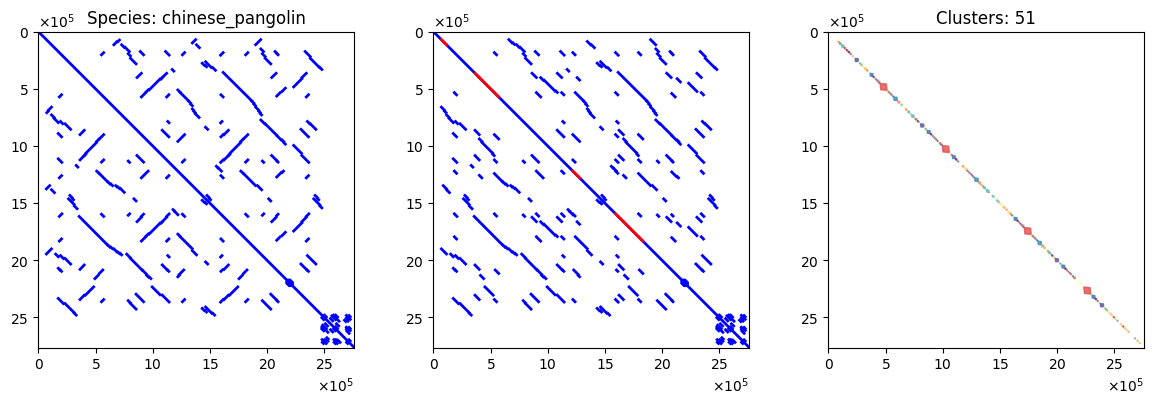

In [12]:
import utilx2
reload(utilx2)
from utilx2 import find_split_points_dbscan, split_segments_by_values, loop, make_fig, plot_necklace

make_fig(df4_v2, df6, df8, df10, res_dir, species_name)


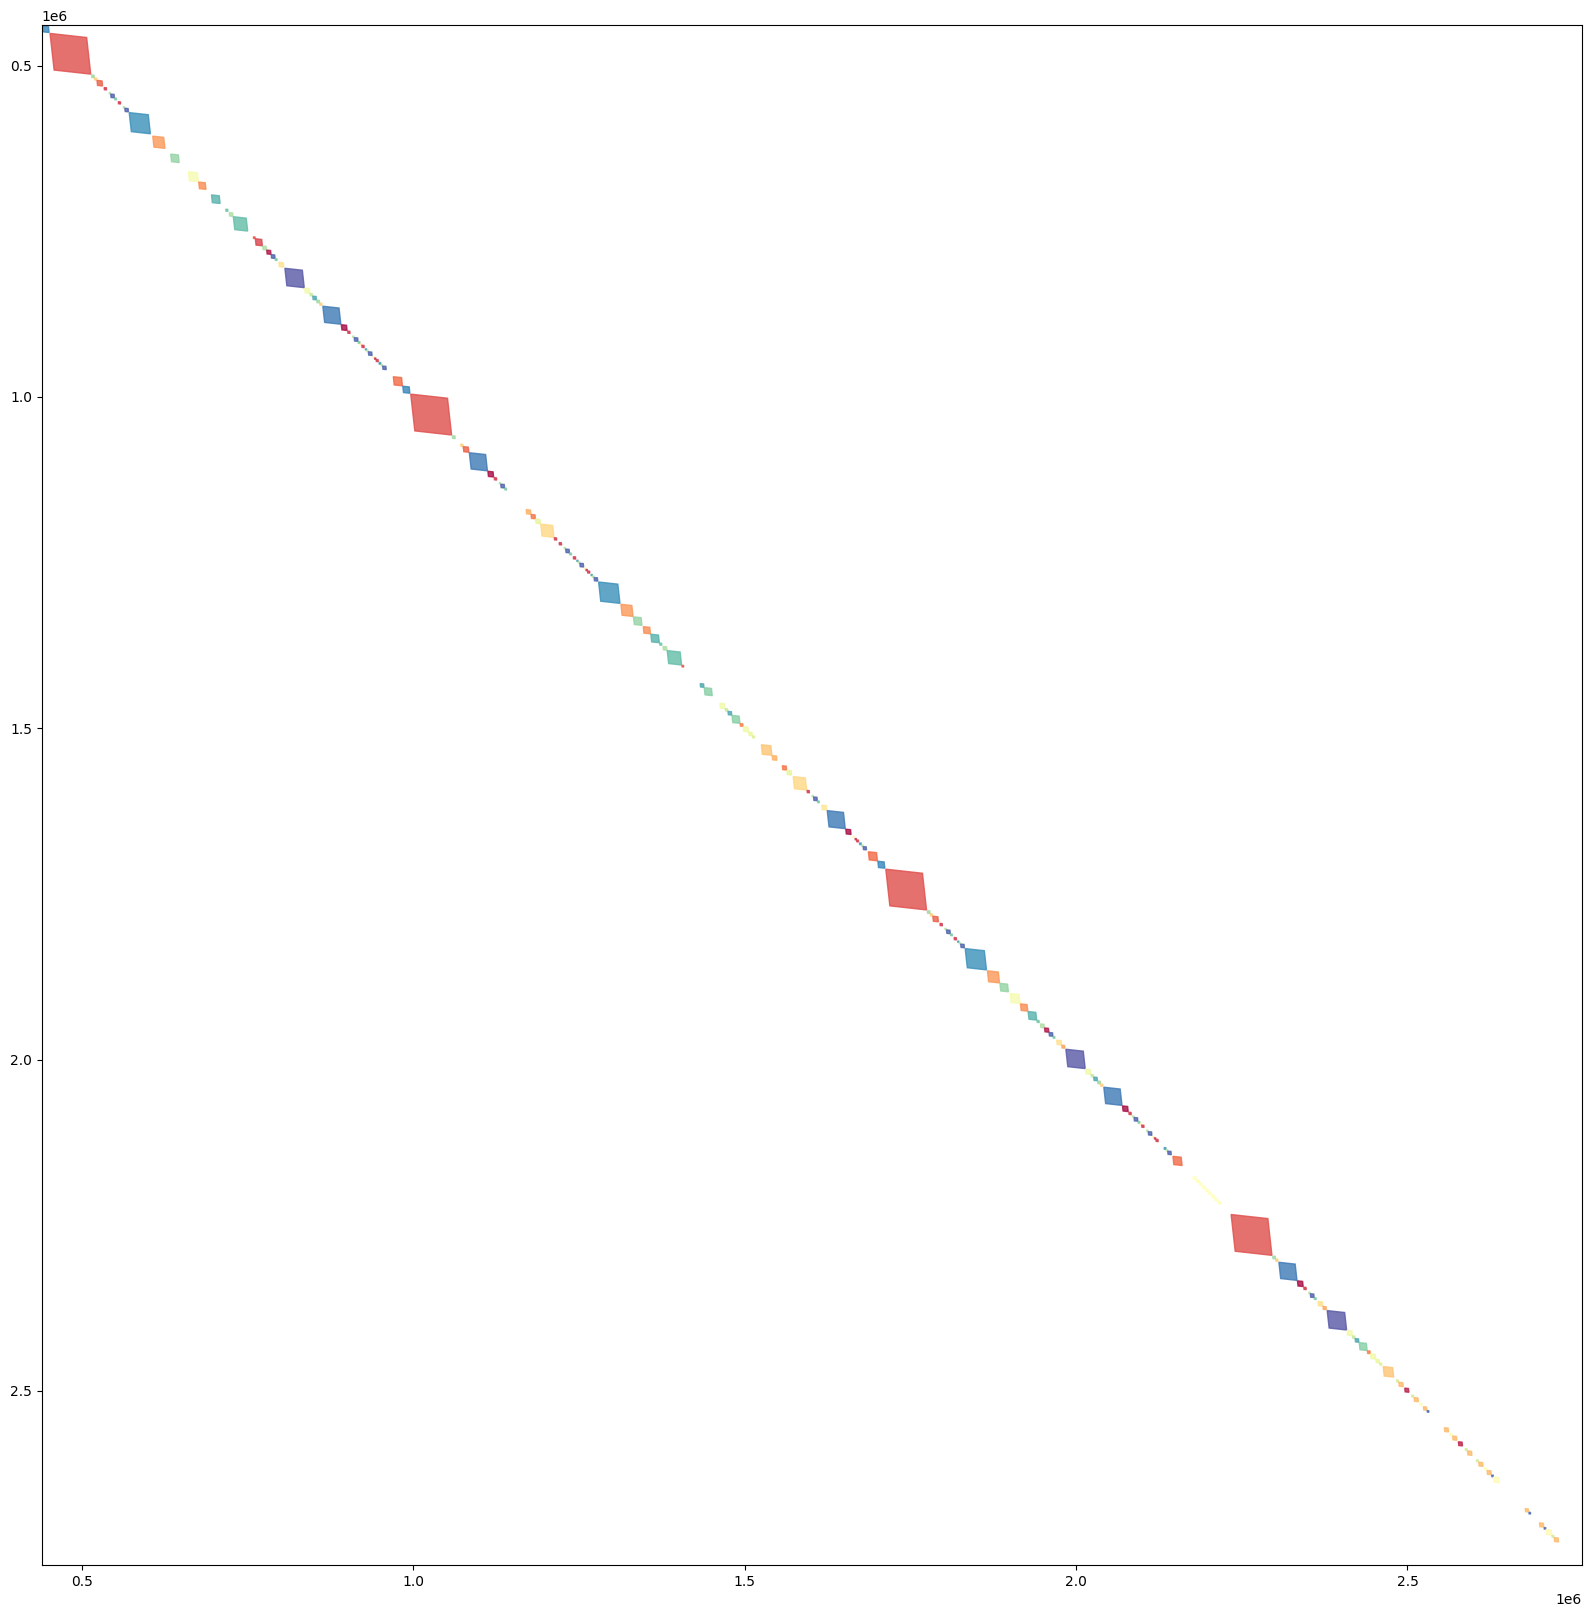

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

colors = plot_necklace(ax, df8, s_min = 440000, e_max = df4_v2.x2.max())


In [14]:
print(dfw.head())
print(dfw.tail())

   seq_id       x1         y1         x2         y2 strand2     role
0       0      1.0        1.0  2762011.0  2762011.0       +  segment
1     195  69286.0  1374998.0    97785.0  1346521.0       -  segment
2     196  69286.0  1944370.0   113485.0  1900215.0       -  segment
3     197  72842.0   708495.0    86355.0   694973.0       -  segment
4     198  86337.0   687072.0   113842.0   659726.0       -  segment
     seq_id         x1         y1         x2         y2 strand2  \
549     193  2717898.0  2695433.0  2728219.0  2705909.0       +   
550     190  2717898.0  2483294.0  2728239.0  2493933.0       +   
551     191  2717898.0  2586949.0  2728239.0  2597600.0       +   
552     192  2717898.0  2603706.0  2728239.0  2614182.0       +   
553     194  2717902.0  2506227.0  2728239.0  2516816.0       +   

                  role  
549  segment_reflected  
550  segment_reflected  
551  segment_reflected  
552  segment_reflected  
553  segment_reflected  


In [15]:
print(dfw_clusters.head())
print(dfw_clusters.tail())

  role             x1             x2  cluster reverse
0  NaN   69645.000000   85307.666667        1     NaN
1  NaN   85344.250000   96759.500000        2     NaN
2  NaN   96792.000000  110242.500000        3     NaN
3  NaN  110287.000000  113840.333333        4     NaN
4  NaN  114214.666667  136621.000000        5     NaN
               role         x1         x2  cluster reverse
268  reverse_region  1219653.0  1278423.0       -1    True
269  reverse_region  1593372.0  1616016.0       -1    True
270  reverse_region  1623866.0  1661533.0       -1    True
271  reverse_region  1663147.0  1792440.0       -1    True
272  reverse_region  1794352.0  1831812.0       -1    True
